In [ ]:
!pip install SoccerNet 
!pip uninstall wandb -y
import SoccerNet
from SoccerNet.Downloader import SoccerNetDownloader
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import cv2
from glob import glob
import re
import yaml

In [ ]:
yolo_base = '/content/yolov7'
sn_track_base = '/content/tracking'
!nvidia-smi

Tue Dec  6 17:02:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# I will only download the train and test dataset due to disk space limitations on colab environment.

!mkdir -p $sn_track_base
# !touch $sn_track_base/test.zip
!touch $sn_track_base/challenge.zip

mySoccerNetDownloader=SoccerNetDownloader(LocalDirectory="/content/")
mySoccerNetDownloader.downloadDataTask(task="tracking", split=["train", "test", "challenge"])
!unzip -q -d $sn_track_base $sn_track_base/train.zip
!unzip -q -d $sn_track_base $sn_track_base/test.zip

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7 
!cd $yolo_base && wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6_training.pt

In [ ]:
# Of the 57 half , 50 are used for training and 7 for validation.
trn_dirs = sorted(glob(f'{sn_track_base}/train/SNMOT*'))
tst_dirs = sorted(glob(f'{sn_track_base}/test/SNMOT*'))
# tst_dirs = trn_dirs[50:]
# trn_dirs = trn_dirs[:50]

debug=False
if debug:
    trn_dirs = trn_dirs[:25]
    tst_dirs = tst_dirs[:]

split_dirs = {
    'train':trn_dirs,
    'valid':tst_dirs
}

# ４ types of labels are used.
labels = ['ball', 'player', 'referee', 'goalkeepers']
label_dict = {'ball': 0, 'player': 1, 'referee': 2, 'goalkeeper': 3, 'goalkeepers': 3}

# labels = ['ball', 'player team left', 'player team right', 'referee', 'goalkeepers']
# label_dict = {'ball': 0, 'player team left': 1, 'player team right': 2, 'referee': 3, 'goalkeeper': 4, 'goalkeepers': 4}

In [ ]:
#(1) image file path
yolo_train_img_dir = f'{yolo_base}/images/train'
yolo_valid_img_dir = f'{yolo_base}/images/valid'

#(2) label file path
yolo_train_label_dir = f'{yolo_base}/labels/train'
yolo_valid_label_dir = f'{yolo_base}/labels/valid'

#(3) config file path
yaml_file = f'{yolo_base}/data.yaml'

os.makedirs(yolo_train_img_dir, exist_ok=True)
os.makedirs(yolo_valid_img_dir, exist_ok=True)
os.makedirs(yolo_train_label_dir, exist_ok=True)
os.makedirs(yolo_valid_label_dir, exist_ok=True)

In [ ]:
# convert from x,y,w,h to yolo format
def get_yolo_format_bbox(img_w, img_h, box):
  w = box[2]
  h = box[3]
  xc = box[0] + int(np.round(w/2))
  yc = box[1] + int(np.round(h/2))
  box = [xc/img_w, yc/img_h, w/img_w, h/img_h]
  box = [f"{i:.4g}" for i in box]
  return box
    
# get SoccerNet label info 
def get_info(info):
  results = []
  for line in open(info):
    m = re.match('trackletID_(\d+)= (\S*).*', line.replace(';', ' '))
    if m:
      # print(m, m.group(2))
      if m.group(2) not in label_dict:
        print('bad label:', m.group(2))
        continue 
      results.append([m.group(1), m.group(2)])
  return pd.DataFrame(results, columns=['id','lbl']).set_index('id').to_dict()['lbl']

# make image simlink and label files
for split in split_dirs:
  if split == 'train':
    yolo_img_dir = yolo_train_img_dir
    yolo_label_dir = yolo_train_label_dir
  else:
    yolo_img_dir = yolo_valid_img_dir
    yolo_label_dir = yolo_valid_label_dir
      
  for this_dir in split_dirs[split]:
    print('this_dir:',this_dir)
    video = this_dir.split('/')[-1]
    info = this_dir + '/gameinfo.ini'
    det = this_dir + '/gt/gt.txt'
    info_dict = get_info(info)
    det_df = pd.read_csv(det, names=['frame','player','x','y','w','h','f1','f2','f3','f4'], usecols=['frame','player','x','y','w','h'])
    det_df['label'] = det_df.player.astype(str).map(info_dict)
    det_df['label_id'] = det_df['label'].map(label_dict)

    # check
    ng_list = list(det_df[det_df.label_id.isnull()].label.unique())
    if len(ng_list)>0:
      #print('ng_list:',ng_list, det_df.dropna().shape, det_df.shape)
      det_df = det_df.dropna()
    for grp, grp_df in det_df.groupby('frame'):
      frame = f'{grp:06}'
      img_file = f'{this_dir}/img1/{frame}.jpg'
      dst_file = f'{yolo_img_dir}/{video}_{frame}.jpg'
      if not os.path.exists(dst_file):
        os.symlink(img_file, dst_file)
        #print(img_file)
      img = cv2.imread(dst_file)
      height, width, _ = img.shape 
      bboxes = []
      for arr in grp_df[['x', 'y', 'w', 'h', 'label_id']].values:
        box = get_yolo_format_bbox(width, height, arr[:4])
        bboxes.append([arr[4]]+box)
      file_name = f'{yolo_label_dir}/{video}_{frame}.txt'
      with open(file_name, 'w') as f:
        for i, bbox in enumerate(bboxes):
          bbox = [str(i) for i in bbox]
          str_bbox = ' '.join(bbox)
          f.write(str_bbox)
          f.write('\n')

In [ ]:
# Dump config file
data_yaml = dict(
    train = yolo_train_img_dir,
    val = yolo_valid_img_dir,
    nc = 4,
    names = labels
)

with open(yaml_file, 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [ ]:
# train!
!cd $yolo_base && time python train_aux.py \
    --workers 48 \
    --batch-size 42 \
    --data data.yaml \
    --img 512 \
    --epochs 2 \
    --cfg cfg/training/yolov7-w6.yaml \
    --weights yolov7-w6_training.pt \
    --name yolov7-w6-custom \
    --hyp data/hyp.scratch.custom.yaml

YOLOR 🚀 v0.1-116-g8c0bf3f torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=42, bbox_interval=-1, bucket='', cache_images=False, cfg='cfg/training/yolov7-w6.yaml', data='data.yaml', device='', entity=None, epochs=2, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.custom.yaml', image_weights=False, img_size=[512, 512], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov7-w6-custom', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov7-w6-custom5', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=42, upload_dataset=False, v5_metric=False, weights='yolov7-w6_training.pt', workers=48, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup

# New Section

In [ ]:
# predict!
check_images = f'{tst_dirs[0]}/img1'
weight_file = 'runs/train/yolov7-w6-custom5/weights/best.pt'
!cd $yolo_base && python detect.py \
    --weights $weight_file \
    --source  $check_images \
    --img-size 768 \
    --project dfl

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=768, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='dfl', save_conf=False, save_txt=False, source='/content/tracking/test/SNMOT-116/img1', update=False, view_img=False, weights=['runs/train/yolov7-w6-custom5/weights/best.pt'])
YOLOR 🚀 v0.1-116-g8c0bf3f torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
IAuxDetect.fuse
Model Summary: 370 layers, 80961284 parameters, 0 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
16 players, 1 referee, Done. (23.3ms) Inference, (2.9ms) NMS
 The image wi

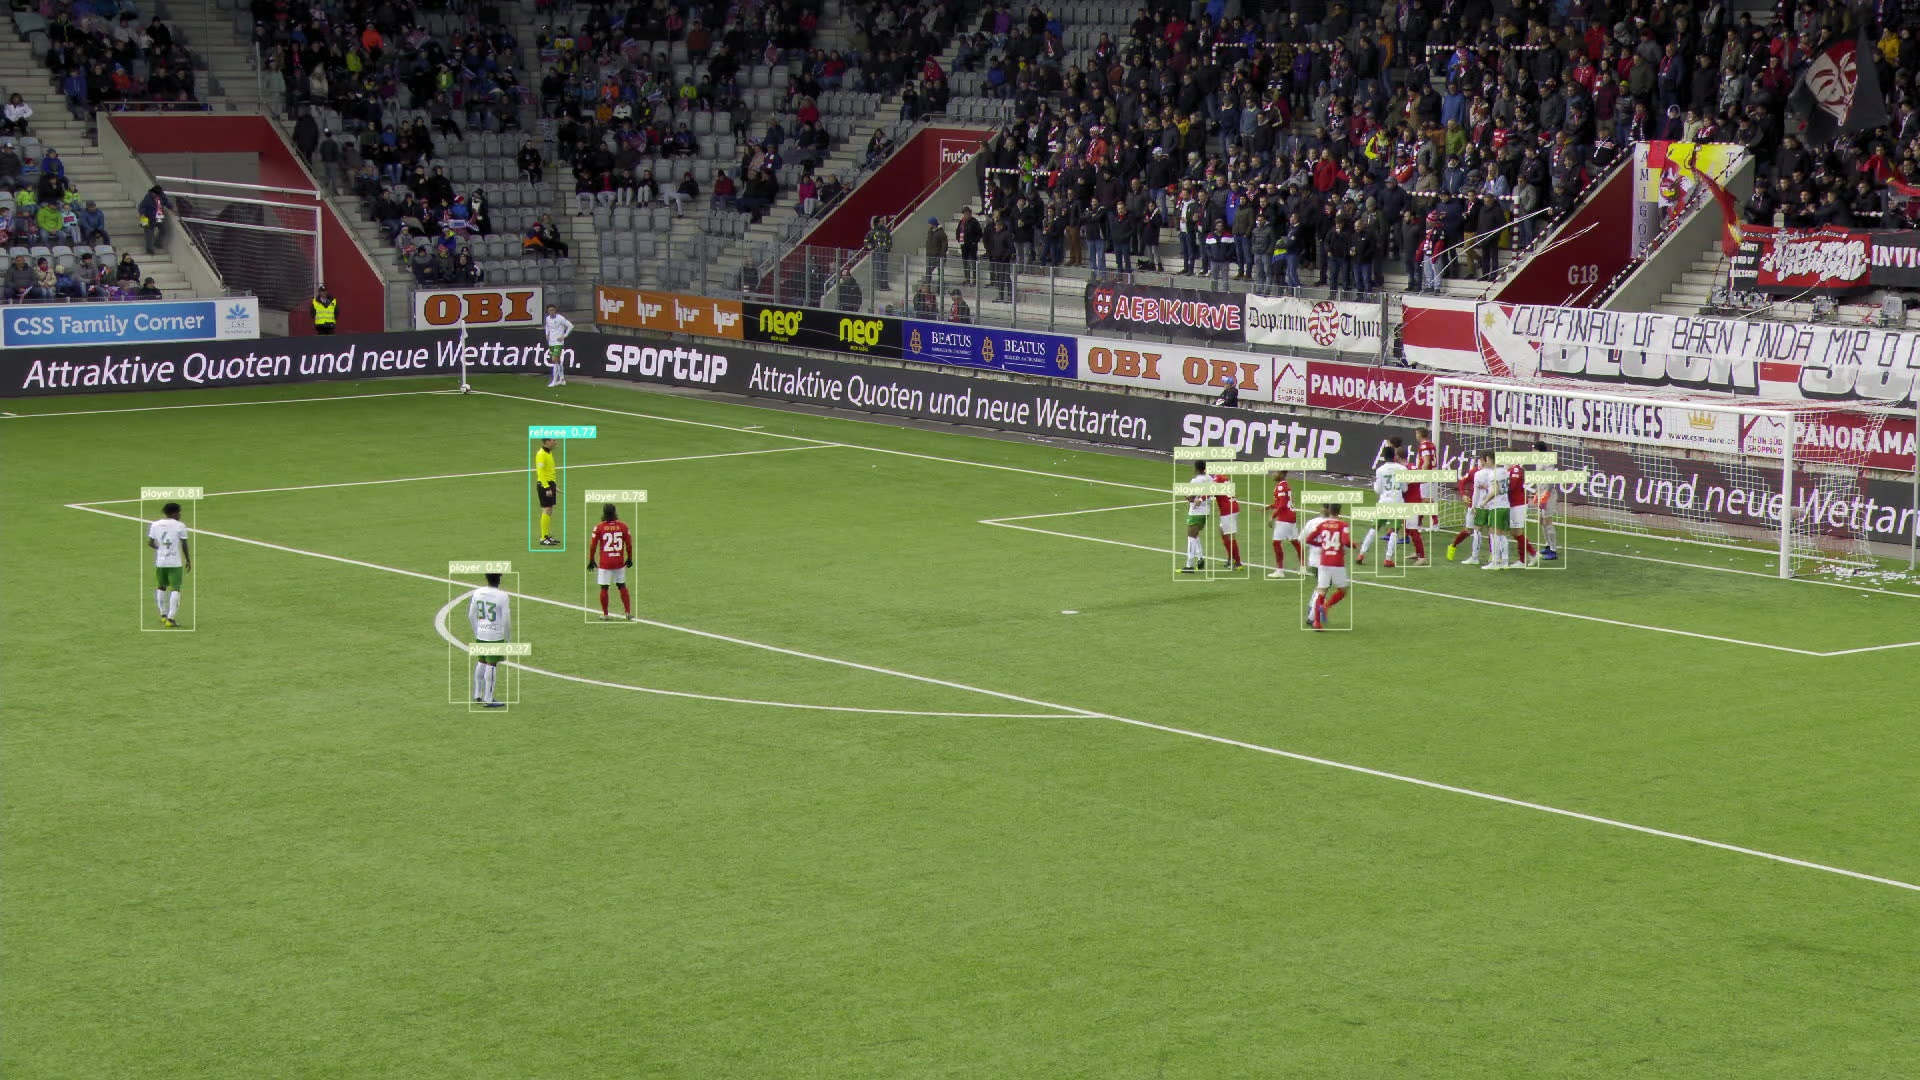

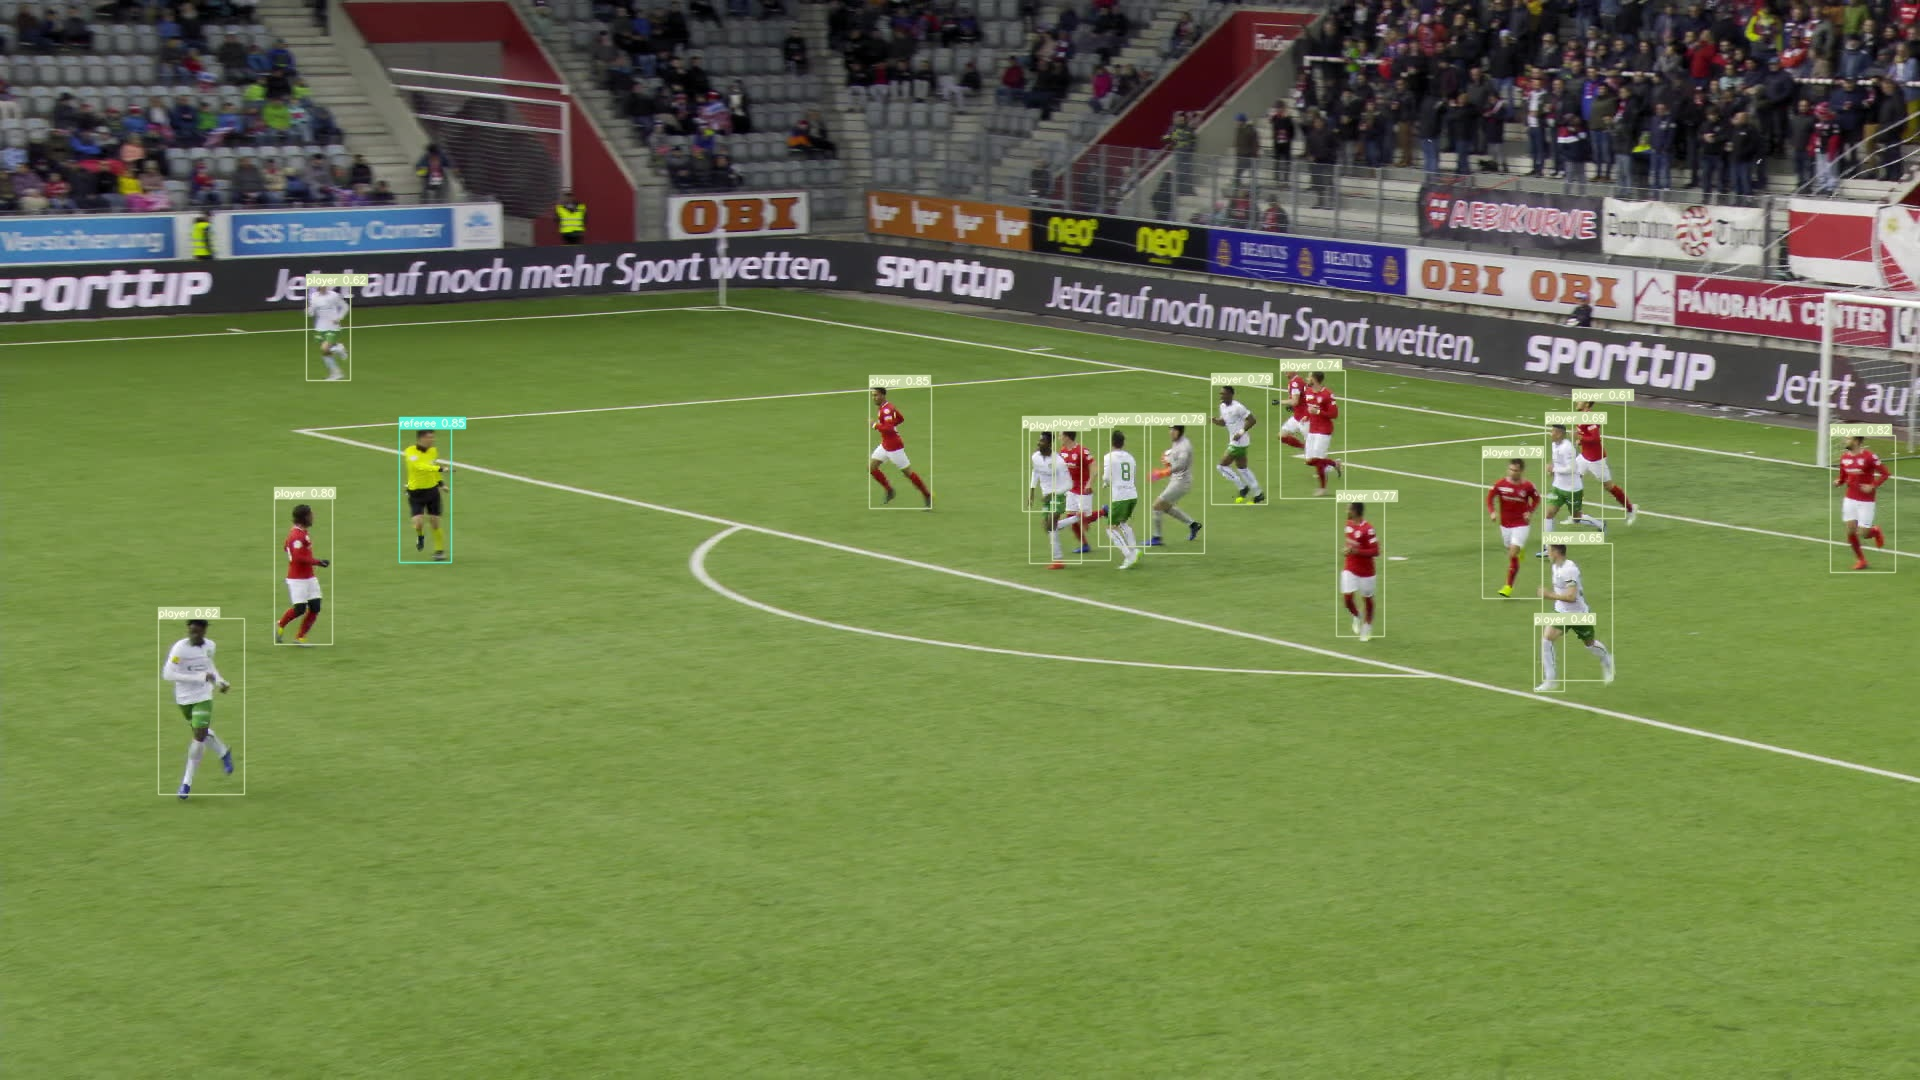

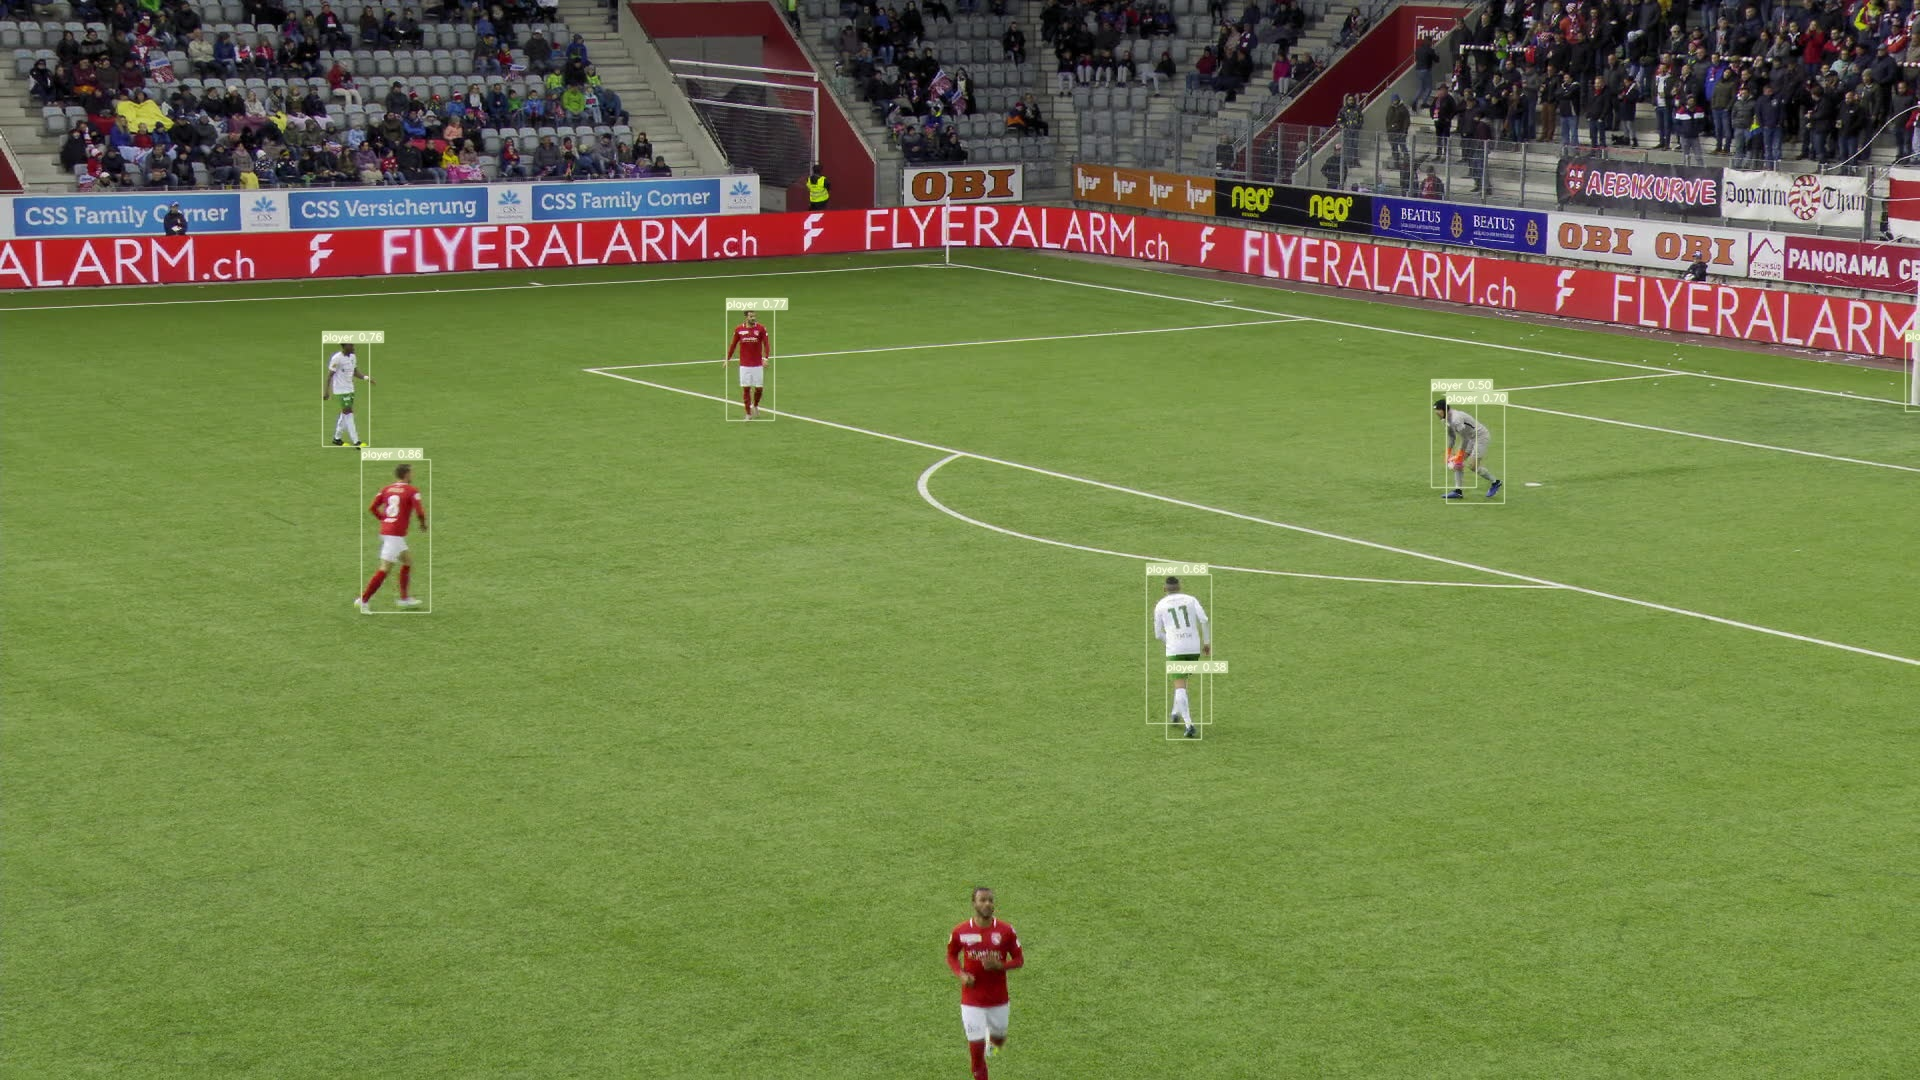

In [ ]:
# Check some results. 
number = 3
display(Image(f'{yolo_base}/dfl/exp/000100.jpg'))
display(Image(f'{yolo_base}/dfl/exp/000300.jpg'))
display(Image(f'{yolo_base}/dfl/exp/000500.jpg'))



In [ ]:
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
rar is already the newest version (2:5.5.0-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [ ]:
!rar a "/content/dflv.rar" "/content/yolov7/dfl/exp"


RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help

Evaluation copy. Please register.

Cannot open /content/yolov7/dfl/exp3
No such file or directory
Creating archive /content/dflv3.rar



In [ ]:
!rar a "/content/custom.rar" "/content/yolov7/runs/train/yolov7-w6-custom"